In [2]:
import pandas as pd
from tools import *
from CONSTANT import *
import os

from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pd.set_option("display.max_info_columns", 1300)

import gc

%matplotlib inline

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

# HKU956

# threshold determining

In [4]:
# color: https://zhuanlan.zhihu.com/p/457797561
av_rating = pd.read_csv(r'./HKU956/3. AV_ratings_duration.csv')
av_rating['valence'] = av_rating['valence'].apply(lambda x: 1 if x == 'positive' else 0)
av_rating['arousal'] = av_rating['arousal'].apply(lambda x: 1 if x == 'positive' else 0)
del av_rating['play_duration']
av_rating.head()

,participant_id,song_no,song_id,valence_rating,valence,arousal_rating,arousal
0,hku1919,16,370177,9.3,1,1.0,1
1,hku1919,8,1119687,9.8,1,-3.0,0
2,hku1919,18,77933,-0.1,0,1.9,1
3,hku1919,14,238585,1.0,1,-1.8,0
4,hku1919,20,1168711,0.2,1,-3.4,0


In [5]:
from scipy.stats import pearsonr

In [6]:
pearsonr(av_rating['valence_rating'], av_rating['arousal_rating'])

(0.17323506672285682, 7.042100721275258e-08)

In [7]:
av_rating['valence'].value_counts()

1    647
0    309
Name: valence, dtype: int64

In [8]:
av_rating['arousal'].value_counts()

1    571
0    385
Name: arousal, dtype: int64

In [9]:
av_rating[av_rating['valence_rating']==' ']

,participant_id,song_no,song_id,valence_rating,valence,arousal_rating,arousal


In [6]:
# minmax_scale(av_rating['valence_rating'])

In [10]:
valence_mip = []
arousal_mip = []

for pid in av_rating['participant_id'].unique():
    kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[av_rating['participant_id']==pid][['valence_rating', 'arousal_rating']])
    midpoint = kmeans.cluster_centers_.sum(axis=0)/2
    valence_mip.append(midpoint[0])
    arousal_mip.append(midpoint[1])

In [11]:
midp_df = pd.DataFrame()
midp_df['participant_id'] = av_rating['participant_id'].unique()
midp_df['v_midp'] = valence_mip
midp_df['a_midp'] = arousal_mip
av_rating = av_rating.merge(midp_df, on='participant_id', how='left')

In [13]:
def determine(rating, midp):
    return 1 if rating > midp else 0

def determine4(v_rating, a_rating, v_midp, a_midp):
    if v_rating < v_midp and a_rating < a_midp: # LVLA
        return 0
    elif v_rating < v_midp and a_rating >= a_midp: # LVHA
        return 1
    elif v_rating >= v_midp and a_rating < a_midp: # HVLA
        return 2
    elif v_rating >= v_midp and a_rating >= a_midp: # HVHA
        return 3
    else:
        return None

av_rating['valence_label'] = av_rating.apply(lambda x: determine(x.valence_rating, x.v_midp), axis=1)
av_rating['arousal_label'] = av_rating.apply(lambda x: determine(x.arousal_rating, x.a_midp), axis=1)
av_rating['4d'] = av_rating.apply(lambda x: determine4(x.valence_rating, x.arousal_rating, x.v_midp, x.a_midp), axis=1)

In [14]:
av_rating['valence_label'].value_counts()

1    552
0    404
Name: valence_label, dtype: int64

In [15]:
av_rating['arousal_label'].value_counts()

1    498
0    458
Name: arousal_label, dtype: int64

In [16]:
av_rating['4d'].value_counts()

3    317
2    235
0    223
1    181
Name: 4d, dtype: int64

In [17]:
del av_rating['v_midp']
del av_rating['a_midp']

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 10))
av_rating['arousal_rating'] = scaler.fit_transform(av_rating['arousal_rating'].values.reshape(-1, 1)).flatten()
scaler = MinMaxScaler(feature_range=(1, 10))
av_rating['valence_rating'] = scaler.fit_transform(av_rating['valence_rating'].values.reshape(-1, 1)).flatten()

## clutering before minmax

In [34]:
# colors = ["#8ECFC9", "#FF9C34", "#4E9A06"]

# kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
# plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
#             facecolors='none', edgecolors=['#8ECFC9' if i==0 else '#FFBE7A' for i in kmeans.labels_ ], s=4)
# plt.ylabel('arousal')
# plt.xlabel('valence')
# plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='#FA7F6F', marker="o", markersize=3)
# threshold = kmeans.cluster_centers_.sum(axis=0)/2
# plt.plot(threshold[0], threshold[1], c='red', marker="+", markersize=20)
# kmeans.cluster_centers_.sum(axis=0)/2

In [35]:
# midpoint = kmeans.cluster_centers_.sum(axis=0)/2
# av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
# av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
# av_rating.head()

In [9]:
# av_rating['valence_label'].value_counts()

1    489
0    467
Name: valence_label, dtype: int64

In [10]:
# av_rating['arousal_label'].value_counts()

1    502
0    454
Name: arousal_label, dtype: int64

# signal processing

In [36]:
def signal_processer(user, signal_name, signal_files, output_fs=64, win_size=4, step=2):
    all_signals = {}
    tmp_signals = []
    va_info_col = ['participant_id', 'song_no', 'song_id', 'valence_rating',
                   'valence', 'arousal_rating', 'arousal', 'play_duration']
    for file in signal_files:
        try:
            filename = os.path.split(file)[-1]
            filename, file_extension = os.path.splitext(filename)
            if file_extension != '.csv':
                continue
            # songno, songid = filename.split('_')
            
            signal = pd.read_csv(file, header=None).iloc[:,0].values

            # bandpass or lowpass filtering & resampling
            if signal_name == 'EDA':
                signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=output_fs)
            elif signal_name in ['TEMP', 'BVP']:
                signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=output_fs)
            elif signal_name == 'HR':
                # signal = chauvenet_filter(signal)
                # print(signal)
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=output_fs)
            else: # IBI
                continue

            tmp_signals.extend(signal.tolist())
            all_signals[filename] = signal
            
        except Exception as e:
            print(e, file)
            raise e
        
    signal_max = np.max(tmp_signals)
    signal_min = np.min(tmp_signals)

    del tmp_signals

    signal_df = []

    # normalization, segmentation, $ concatenation
    for filename, signal in all_signals.items():
        song_no, song_id = filename.split('_')
        signal = (signal - signal_min) / (signal_max - signal_min)
        signal = pd.Series(signal).interpolate().tolist()
        
        # segments = np.array(segment_generator(signal, win_size=win_size*100, step=step*100)[1:])
        segments = np.array(segment_generator(signal, win_size=win_size*output_fs, step=step*output_fs))[-1:]
        seg_cols = ['{}_seg{}'.format(signal_name, i) for i in range(segments.shape[1])]
        segment_df = pd.DataFrame(columns=seg_cols, data=segments)

        segment_df['segment_id'] = segment_df.index.tolist()
        segment_df['song_no'] = int(song_no)
        segment_df['song_id'] = int(song_id)
        segment_df['participant_id'] = user

        # va_info = [av_rating[(av_rating['participant_id']==user) & (av_rating['song_no']==int(songno)) & (av_rating['song_id']==int(songid))].values.tolist()[0] for _ in range(len(segments))]
        # tmp_va_info = pd.DataFrame(columns=va_info_col, data=va_info)
        # segment_df = pd.concat([tmp_va_info, segment_df], axis=1)
        
        signal_df.append(segment_df)
    
    return pd.concat(signal_df)

In [37]:
win_size = 12
step = 4

In [38]:
users = os.listdir(HKU_DIR)
signal_dfs = {}

# for signal_name in ['HR']:
for signal_name in SIGNALS:
    if signal_name == 'IBI':
        continue
    signals = []
    for user in users:
        signal_files = get_folder_files(os.path.join(HKU_DIR, user, signal_name))
        signal_df = signal_processer(user, signal_name, signal_files, win_size=win_size, step=step)
        signals.append(signal_df)
        # break
    signals = pd.concat(signals)
    # signals.to_csv(os.path.join(PROCESSED_DIR, 'HKU956', '{}.csv'.format(signal_name)), index=False)
    print(signal_name, signals.shape)
    signal_dfs[signal_name] = signals

BVP (956, 772)
EDA (956, 772)
HR (956, 772)
TEMP (956, 772)


In [39]:
bvp_eda_df = signal_dfs['BVP'].merge(signal_dfs['EDA'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
bvp_eda_hr_df = bvp_eda_df.merge(signal_dfs['HR'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
del bvp_eda_df
bvp_eda_hr_temp_df = bvp_eda_hr_df.merge(signal_dfs['TEMP'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
del bvp_eda_hr_df
print(bvp_eda_hr_temp_df.isnull().sum().sum(), bvp_eda_hr_temp_df.shape)
bvp_eda_hr_temp_df = reduce_mem_usage(bvp_eda_hr_temp_df, un_process=['segment_id', 'song_no', 'song_id', 'participant_id'])
gc.collect()

0 (956, 3076)
Mem. usage decreased to  5.64 Mb (74.9% reduction)
Final (956, 3076)


0

In [24]:
all_signals_df = bvp_eda_hr_temp_df.merge(av_rating, on=['participant_id', 'song_no', 'song_id'])
del all_signals_df['segment_id'], all_signals_df['song_no'], bvp_eda_hr_temp_df
print(all_signals_df.info())
print(all_signals_df.isnull().sum().sum())
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 955
Columns: 3081 entries, BVP_seg0 to 4d
dtypes: float16(3072), float64(2), int64(6), object(1)
memory usage: 5.7+ MB
None
0


0

In [40]:
# all_signals_df.to_csv(r'./processed_signal/HKU956/400_4s_step_2s.csv', index=False)
# all_signals_df.to_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
all_signals_df.to_pickle(r'./processed_signal/HKU956/956_{}_{}s_step_{}s.pkl'.format(win_size*64+4, win_size, step))


In [41]:
all_signals_df['valence_label'].value_counts(), all_signals_df['arousal_label'].value_counts()

(1    552
 0    404
 Name: valence_label, dtype: int64,
 1    498
 0    458
 Name: arousal_label, dtype: int64)

# generating train_test spliter

In [111]:
# all_signals_df = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')

In [42]:

kfolds = [5, 10]

for kfold in kfolds:
    feature_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in SIGNALS]
    target_cols = ['valence', 'arousal', 'arousal_rating', 'valence_rating', 'arousal_label', 'valence_label']
    group_cols = ['participant_id', 'song_id']

    spliter = {'cv': [], 'loso': [], 'loao': []}

    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=31)
    for train_index, test_index in skf.split(all_signals_df[feature_cols], all_signals_df['valence_label']):
        spliter['cv'].append({'train_index': train_index, 'test_index': test_index})

    loso_skgf = StratifiedGroupKFold(n_splits=kfold, shuffle=True, random_state=31)
    for train_index, test_index in loso_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_label'], groups=all_signals_df['participant_id']):
        spliter['loso'].append({'train_index': train_index, 'test_index': test_index})

    loao_skgf = StratifiedGroupKFold(n_splits=kfold, shuffle=True, random_state=31)
    for train_index, test_index in loao_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_label'], groups=all_signals_df['song_id']):
        spliter['loao'].append({'train_index': train_index, 'test_index': test_index})

    save_model(r'./processed_signal/HKU956/956_{}_{}s_step_{}s_spliter{}.pkl'.format(win_size*64+4, win_size, step, kfold), spliter)

./processed_signal/HKU956/956_772_12s_step_4s_spliter5.pkl saved done!
./processed_signal/HKU956/956_772_12s_step_4s_spliter10.pkl saved done!


In [43]:
# spliter = load_model(r'./processed_signal/HKU956/last15_400_4s_step_2s_spliter10.pkl')
print(len(spliter['loso'][0]['train_index']), len(spliter['loso'][0]['test_index']))
print(len(spliter['loao'][0]['train_index']), len(spliter['loao'][0]['test_index']))
print(len(spliter['cv'][0]['train_index']), len(spliter['cv'][0]['test_index']))

850 106
858 98
860 96


In [80]:
# spliter = load_model(r'./processed_signal/HKU956/last15_400_4s_step_2s_spliter10.pkl')
print(len(spliter['loso'][0]['train_index']), len(spliter['loso'][0]['test_index']))
print(len(spliter['loao'][0]['train_index']), len(spliter['loao'][0]['test_index']))
print(len(spliter['cv'][0]['train_index']), len(spliter['cv'][0]['test_index']))

5552 1386
5276 1662
5550 1388


# data generator

In [25]:
def join_signals(df, target='valence'):
    bvp_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['BVP']]
    eda_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['EDA']]
    temp_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['TEMP']]
    hr_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['HR']]

    target_cols = ['valence', 'arousal', 'arousal_rating', 'valence_rating']
    group_cols = ['participant_id', 'song_id']

    signal_concats = []
    for bvp, eda, temp, hr in zip(df[bvp_cols].values, df[eda_cols].values, df[temp_cols].values, df[hr_cols].values):
        signal_concats.append([bvp, eda, temp, hr])

    return np.array(signal_concats), df[target].values

In [162]:
train_index = spliter['loso'][0]['train_index']
test_index = spliter['loso'][0]['test_index']

target_col = 'valence'

df = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
# train_df = df.iloc[train_index]
# test_df = df.iloc[test_index]
X, y = join_signals(df, target='valence')

In [165]:
train_X, train_y, test_X, test_y = X[train_index], y[train_index], X[test_index], y[test_index]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((18089, 4, 400), (18089,), (4638, 4, 400), (4638,))

In [15]:
df = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')

In [57]:
hr_signal = pd.read_csv(r'./HKU956/1. physiological_signals/hku1903/TEMP/0_262957.csv', header=None)

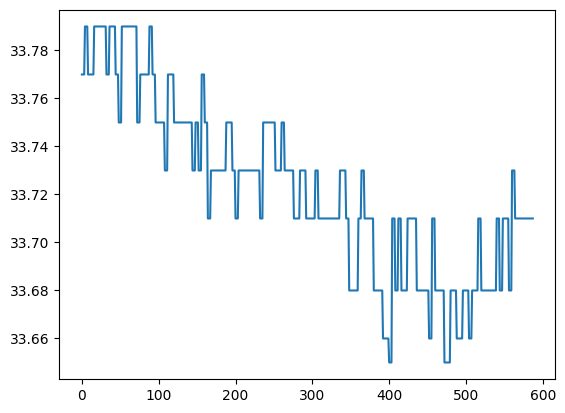

In [58]:
plt.plot([i for i in range(len(hr_signal))], hr_signal)

# KEmoCon

In [ ]:
# The last 6 digits are multiperspective emotion annotations associated with the segment, in the order of 1) self-arousal, 2) self-valence, 3) partner-arousal, 4) partner-valence, 5) external-arousal, and 6) external-valence.

In [88]:
# bandpass or lowpass filtering & resampling
def ke_signal_processing(file, signal_content, all_signals, tmp_signals, output_fs=100):
    all_signals[file.replace('.json', '')] = {}
    for signal_name, signal in signal_content.items():
        signal_name = signal_name.upper()
        try:
            # bandpass or lowpass filtering & resampling
            if signal_name == 'EDA':
                signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=output_fs)
            elif signal_name in ['TEMP', 'BVP']:
                signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=output_fs)
            elif signal_name == 'HR':
                # signal = chauvenet_filter(signal)
                # print(signal)
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=output_fs)
            else: # IBI
                continue

            tmp_signals[signal_name].extend(signal.tolist())
            all_signals[file.replace('.json', '')][signal_name] = signal
            
        except Exception as e:
            print(e, file)
            raise e
    
    return tmp_signals, all_signals

In [44]:
error_signal = []
participant_ids = [1, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
signal_df = []
for id_ in tqdm(participant_ids):
    all_signals = {}
    signal_max, signal_min = 0, 0
    tmp_signals = {signal_type: [] for signal_type in ['BVP', 'EDA', 'HR', 'TEMP']}
    for root, dir_, files in os.walk(os.path.join(KEC_DIR, str(id_))):
        for file in files:
            raw_signals = load_json(os.path.join(root, file))
            filename = (file.replace('.json', '').split('-'))[-1]
            mp_signals, all_signals = ke_signal_processing(file, raw_signals, all_signals, tmp_signals)
            valence = int(filename[0])
            arousal = int(filename[1])

    for signal_type in ['BVP', 'EDA', 'HR', 'TEMP']:
        tmp_signals_type = tmp_signals[signal_type]    
        tmp_signals[signal_type] = [np.max(tmp_signals_type), np.min(tmp_signals_type)]


    user_signals = []
    for file, signal_content in all_signals.items():
        file_signal = []
        if len(list(signal_content.keys())) != 4:
            continue
        for signal_type in ['BVP', 'EDA', 'HR', 'TEMP']:
            signal = signal_content[signal_type]
            signal = (signal - tmp_signals[signal_type][1]) / (tmp_signals[signal_type][0] - tmp_signals[signal_type][1])
            signal = pd.Series(signal).interpolate().tolist()
            if len(signal) != 500:
            # if len(signal) != 500:
                error_signal.append({file: [signal_type, signal]})
                continue
            signal = signal[100:]
            seg_cols = ['{}_seg{}'.format(signal_type, i) for i in range(len(signal))]
            seg_df = pd.DataFrame(data=[signal], columns=seg_cols)
            file_signal.append(seg_df)
        if len(file_signal) == 0:
            continue
        file_signal = pd.concat(file_signal, axis=1)
        file_signal['file'] = file
        user_signals.append(file_signal)
    if len(user_signals) == 0:
        continue
    user_signals = pd.concat(user_signals)
    signal_df.append(user_signals)

signal_df = pd.concat(signal_df)

100%|██████████| 26/26 [01:52<00:00,  4.34s/it]


In [45]:
e_signal_df = []
file_signal = {}
for row in error_signal:
    file = list(row.keys())[0]
    if file not in file_signal:
        file_signal[file] = {}
    file_signal[file][row[file][0]] = row[file][1]

for file, signal_content in file_signal.items():
    file_signal = []
    for signal_type in ['BVP', 'EDA', 'HR', 'TEMP']:
        signal = np.array(signal_content[signal_type])
        signal = signal.reshape(2, -1)[:, 100:]
        seg_cols = ['{}_seg{}'.format(signal_type, i) for i in range(len(signal[0]))]
        seg_df = pd.DataFrame(data=signal, columns=seg_cols)
        file_signal.append(seg_df)
    file_signal = pd.concat(file_signal, axis=1)
    file_signal['file'] = file
    e_signal_df.append(file_signal)

e_signal_df = pd.concat(e_signal_df)

all_signals_df = pd.concat([signal_df, e_signal_df])

all_signals_df.shape

(3445, 1601)

In [46]:
# 'valence', 'arousal', 'arousal_label', 'valence_label'
all_signals_df['participant_id'] = all_signals_df['file'].apply(lambda x: str(x).split('-')[0])
all_signals_df['valence'] = all_signals_df['file'].apply(lambda x: int(str(x).split('-')[2][1]))
all_signals_df['arousal'] = all_signals_df['file'].apply(lambda x: int(str(x).split('-')[2][0]))

In [47]:
all_signals_df['valence'].value_counts()

3    2011
4     761
2     520
5      84
1      69
Name: valence, dtype: int64

In [48]:
all_signals_df['arousal'].value_counts()

3    1349
2     956
4     715
5     320
1     105
Name: arousal, dtype: int64

array([3.10528494, 3.41268066])

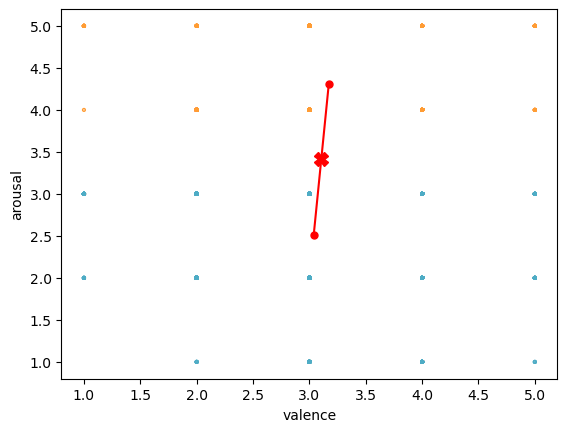

In [49]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(all_signals_df[['valence', 'arousal']])
plt.scatter(y=all_signals_df['arousal'], x=all_signals_df['valence'], 
            facecolors='none', edgecolors=['#4EACC5' if i==0 else '#FF9C34' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='red', marker="o", markersize=5)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="X", markersize=10)
kmeans.cluster_centers_.sum(axis=0)/2

In [50]:
all_signals_df['valence_label'] = all_signals_df['valence'].apply(lambda x: 1 if x > threshold[0] else 0)
all_signals_df['arousal_label'] = all_signals_df['arousal'].apply(lambda x: 1 if x > threshold[1] else 0)

In [54]:
all_signals_df['valence_label'].value_counts()

0    2600
1     845
Name: valence_label, dtype: int64

In [55]:
all_signals_df['arousal_label'].value_counts()

0    2410
1    1035
Name: arousal_label, dtype: int64

In [53]:
all_signals_df = reduce_mem_usage(all_signals_df, un_process=['file', 'participant_id'])
all_signals_df.to_pickle(r'./processed_signal/KEmoCon/KEC_400.pkl')

Mem. usage decreased to 10.61 Mb (74.9% reduction)
Final (3445, 1606)


In [18]:
all_signals_df = pd.read_pickle(r'./processed_signal/KEmoCon/KEC_400.pkl')

In [25]:
feature_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in SIGNALS]
target_cols = ['valence', 'arousal', 'arousal_label', 'valence_label']
group_cols = ['participant_id']
spliter = {'cv': [], 'loso': []}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=31)
for train_index, test_index in skf.split(all_signals_df[feature_cols], all_signals_df['valence_label']):
    spliter['cv'].append({'train_index': train_index, 'test_index': test_index})

loso_skgf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=31)
for train_index, test_index in loso_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_label'], groups=all_signals_df['participant_id']):
    spliter['loso'].append({'train_index': train_index, 'test_index': test_index})

In [26]:
print(len(spliter['loso'][0]['train_index']), len(spliter['loso'][0]['test_index']))

3203 242


In [27]:
save_model(r'./processed_signal/KEmoCon/KEC_400_spliter10.pkl', spliter)

./processed_signal/KEmoCon/KEC_400_spliter10.pkl saved done!


In [59]:
all_signals_df.isnull().sum().sum()

0

In [60]:
all_signals_df.shape

(3445, 1606)

In [61]:
[fea for fea in all_signals_df.columns.tolist() if 'BVP' not in fea and 'EDA' not in fea and 'HR' not in fea and 'TEMP' not in fea]

['file',
 'participant_id',
 'valence',
 'arousal',
 'valence_label',
 'arousal_label']

# resample

In [33]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [34]:
def get_spliter(all_signals_df):

    feature_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in SIGNALS]
    target_cols = ['valence', 'arousal', 'arousal_rating', 'valence_rating', 'arousal_label', 'valence_label']
    group_cols = ['participant_id', 'song_id']

    spliter = {'cv': [], 'loso': [], 'loao': []}

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=31)
    for train_index, test_index in skf.split(all_signals_df[feature_cols], all_signals_df['valence']):
        spliter['cv'].append({'train_index': train_index, 'test_index': test_index})

    loso_skgf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=31)
    for train_index, test_index in loso_skgf.split(all_signals_df[feature_cols], all_signals_df['valence'], groups=all_signals_df['participant_id']):
        spliter['loso'].append({'train_index': train_index, 'test_index': test_index})

    loao_skgf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=31)
    for train_index, test_index in loao_skgf.split(all_signals_df[feature_cols], all_signals_df['valence'], groups=all_signals_df['song_id']):
        spliter['loao'].append({'train_index': train_index, 'test_index': test_index})
    return spliter

In [35]:
all_signals_df = pd.read_pickle(r'./processed_signal/HKU956/last30_400_4s_step_2s.pkl')

all_signals_df.shape

(13381, 1608)

In [81]:
import matplotlib.pyplot as plt

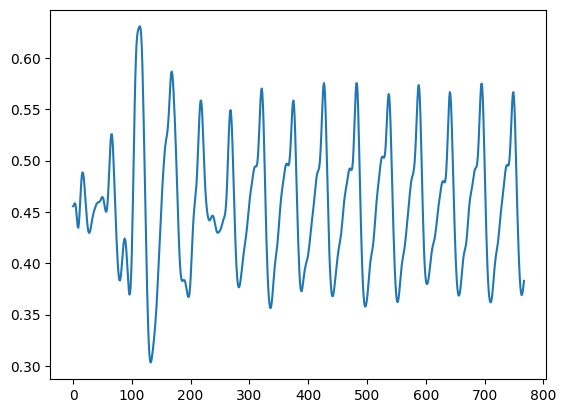

In [87]:
plt.plot([i for i in range(768)], all_signals_df[[fea for fea in all_signals_df.columns if 'BVP' in fea]].iloc[0])

In [22]:
all_signals_df['valence'].value_counts()

1    9055
0    4326
Name: valence, dtype: int64

In [24]:
rus = RandomUnderSampler(random_state=3407)
X = all_signals_df.loc[:, all_signals_df.columns!='valence']
y = all_signals_df['valence']
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled['valence'] = y_resampled
X_resampled['valence'].value_counts()

C:\Users\rlala\AppData\Local\Temp\ipykernel_22256\3615365848.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_resampled['valence'] = y_resampled


0    4326
1    4326
Name: valence, dtype: int64

In [25]:
X_resampled.to_pickle(r'./processed_signal/HKU956/resampled_last30_400_4s_step_2s.pkl')
respliter = get_spliter(X_resampled)
save_model(r'./processed_signal/HKU956/resampled_last30_400_4s_step_2s_spliter10.pkl', respliter)

./processed_signal/HKU956/resampled_last30_400_4s_step_2s_spliter10.pkl saved done!
